In [1]:
%matplotlib inline 
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(theme='onedork')

# Standard Libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate as interp

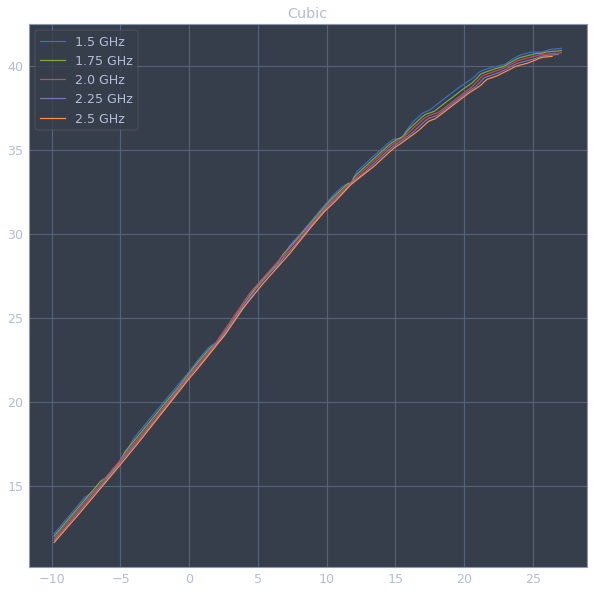

In [2]:
# Load the gain compression file into a data frame from CSV
TGA2976_Gain_Compression = pd.read_csv('TGA2976-SM_Gain_Compress.csv')

grid_freq, grid_pin = np.mgrid[.1:4:201j,-15:30:201j]
#print(grid_pin, '\n')
#print(grid_freq, '\n')

#points = np.random.rand(100, 2)
#print(points)

#print(points[:,0] + points[:,1])
# print(values)
#print(values)
freq1 = list(zip(TGA2976_Gain_Compression['Pout_0.25GHz'],TGA2976_Gain_Compression['Pin_0.25GHz']))
freq2 = list(zip(TGA2976_Gain_Compression['Pout_1GHz'],TGA2976_Gain_Compression['Pin_1GHz']))
freq3 = list(zip(TGA2976_Gain_Compression['Pout_2GHz'],TGA2976_Gain_Compression['Pin_2GHz']))
freq4 = list(zip(TGA2976_Gain_Compression['Pout_3GHz'],TGA2976_Gain_Compression['Pin_3GHz']))

freq1_np = np.asarray(freq1)
freq2_np = np.asarray(freq2)
freq3_np = np.asarray(freq3)
freq4_np = np.asarray(freq4)

freq1_np[:,0] = 0.25
freq2_np[:,0] = 1.0
freq3_np[:,0] = 2.0
freq4_np[:,0] = 3.0
bob = np.concatenate((freq1_np,freq2_np,freq3_np,freq4_np),axis=0)
fred = bob[~np.isnan(bob).any(axis=1)]

Pout_0 = np.concatenate((np.asarray(TGA2976_Gain_Compression['Pout_0.25GHz']),np.asarray(TGA2976_Gain_Compression['Pout_1GHz']),
                       np.asarray(TGA2976_Gain_Compression['Pout_2GHz']),np.asarray(TGA2976_Gain_Compression['Pout_3GHz'])),axis=0)

Pout = Pout_0[np.logical_not(np.isnan(Pout_0))]

#print(Pout,'\n')
#print(fred,'\n')
# print(grid_pin[0,:], '\n')

def get_index(freq):
    index = np.rint(np.interp(freq, grid_freq[:,0], np.linspace(0,200,201)))
    return index.astype(int)



grid_z0 = interp.griddata(fred, Pout, (grid_freq,grid_pin), method='linear')
#print(grid_z0)

plt.plot(grid_pin[0,:],grid_z0[get_index(1.5),:], label='1.5 GHz')
plt.plot(grid_pin[0,:],grid_z0[get_index(1.75),:], label='1.75 GHz')
plt.plot(grid_pin[0,:],grid_z0[get_index(2),:], label='2.0 GHz')
plt.plot(grid_pin[0,:],grid_z0[get_index(2.25),:], label='2.25 GHz')
plt.plot(grid_pin[0,:],grid_z0[get_index(2.5),:], label='2.5 GHz')

# plt.imshow(grid_z0.T, extent=(0,4,-15,30), origin='lower')

plt.title('Cubic')
plt.gcf().set_size_inches(10, 10)
plt.legend()
plt.show()


Now we calculate gain...


No handles with labels found to put in legend.


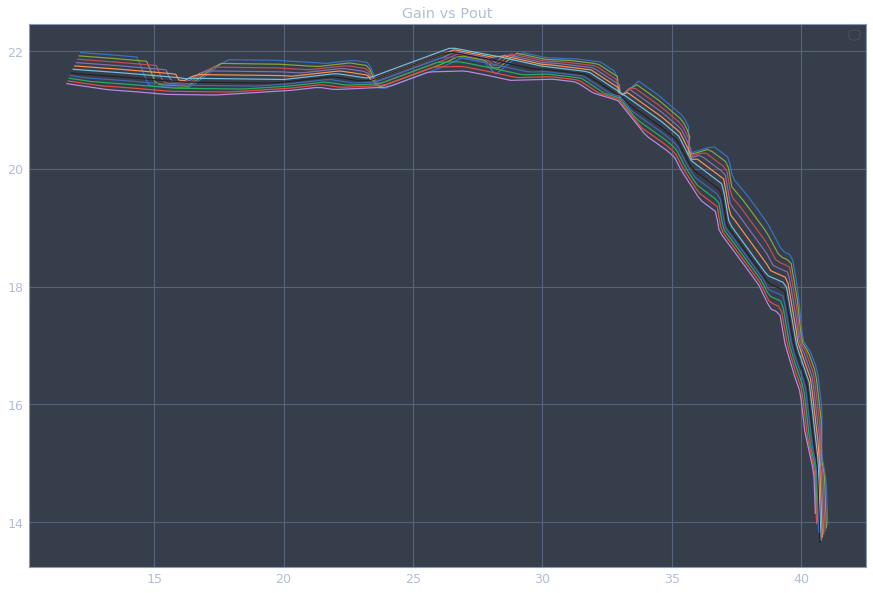

In [7]:
def Calc_Gain(Pin,Pout):
    return Pout - Pin

for freq in np.linspace(1.5,2.5,11):
    plt.plot(grid_z0[get_index(freq),:],Calc_Gain(grid_pin[0,:],grid_z0[get_index(freq),:]))


plt.title('Gain vs Pout')
plt.gcf().set_size_inches(15, 10)
plt.legend()
plt.show()

Now we plot gain comptrssion relative to the average small signal gain at various frequencies. 

First, we define what we consider to be the nominal Pout max across all frequencies for this part as <B>Nom_Pout</B>. We also define what we consider to be adequate backoff to ensure small signal operation as <B>Backoff</B>

/home/bah235/.local/share/virtualenvs/ATE-qetPjp5g/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/home/bah235/.local/share/virtualenvs/ATE-qetPjp5g/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


Index:  133 Power Out:  35.64439305973097
Index:  133 Power Out:  35.592495547828875
Index:  132 Power Out:  35.42084584526985
Index:  132 Power Out:  35.368948333367754
Index:  131 Power Out:  35.15521808470258
Index:  131 Power Out:  35.09677068485573
Index:  130 Power Out:  34.862820614451536
Index:  130 Power Out:  34.80437321460468
Index:  130 Power Out:  34.74592581475783
Index:  130 Power Out:  34.68444050386195
Index:  130 Power Out:  34.62201970837407


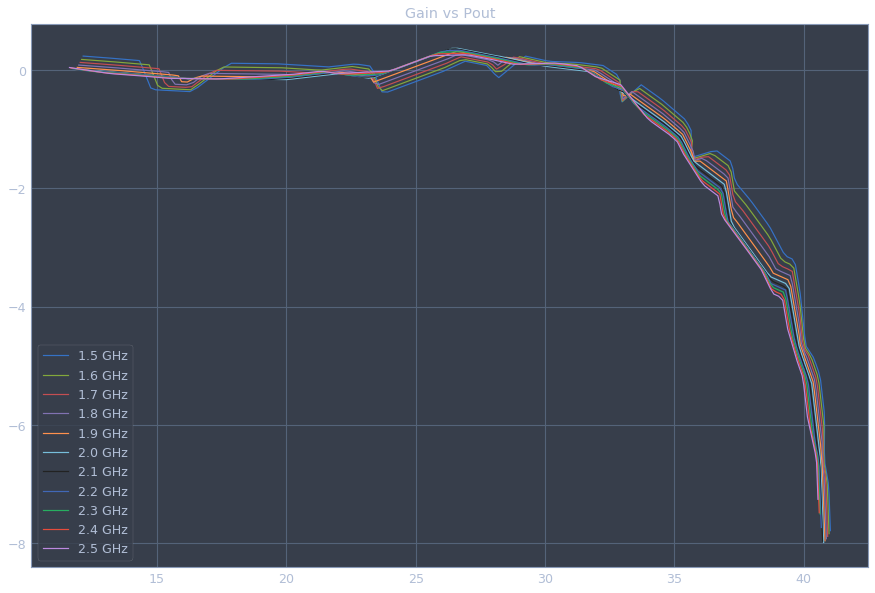

In [4]:
Nom_Pout = 40
Backoff = 10

for freq in np.linspace(1.5,2.5,11):
    Gain_Trace = Calc_Gain(grid_pin[0,:],grid_z0[get_index(freq),:])
    index = np.rint(np.interp((Nom_Pout-Backoff), grid_z0[get_index(freq),:], np.linspace(0,200,201)))
    index = index.astype(int)
    Average = 0
    Count = 0
    for i in range(index):
        if ~np.isnan(Gain_Trace[i]):
            Average = Average + Gain_Trace[i]
            Count = Count + 1
            Avg_Gain = Average/Count
    plt.plot(grid_z0[get_index(freq),:],
             Calc_Gain(grid_pin[0,:],grid_z0[get_index(freq),:])-Avg_Gain, 
             label="{} GHz" .format(freq))
    # We find 1 dB compression from the average backoff gain
    print("Index: ",np.argmax(Gain_Trace<=(Avg_Gain-1)),
          "Power Out: ", grid_z0[get_index(freq),np.argmax(Gain_Trace<=(Avg_Gain-1))])
        
plt.title('Gain vs Pout')
plt.gcf().set_size_inches(15, 10)
#plt.xticks(ticks=x_indexes,labels=ages_x)
plt.legend()
plt.show()